# Training a pre-built model

Feedbax comes with some pre-built model-task pairings, provided by the package `feedbax.xabdeef`. This is the quickest way to train a model of optimal feedback control.

For example, we can train a neural network to move a Newtonian *point mass*—which has mass but no size, and obeys $F=m\cdot a$—between points in a 2D plane.

In [2]:
import jax

from feedbax.xabdeef import point_mass_nn_simple_reaches

In [3]:
key = jax.random.PRNGKey(0)
context = point_mass_nn_simple_reaches(key=key)

!!! NOTE     
    Feedbax is a JAX library, so we'll always explicitly pass a `key` when our code needs to generate random numbers, such as when generating process noise or task trials. This ensures that our results are reproducible, in a stricter and more transparent way than is typical for random number generation in NumPy or PyTorch.

Pre-built pairings are wrapped in a `TrainingContext` object, which holds on to the task (`context.task`) and the initialized model (`context.model`). In particular, the task is an instance of `RandomReaches`. Its training trials are reaches with endpoints that are uniformly distributed in a 2D workspace, and it provides only simple target cues (i.e. without a hold/go signal) as inputs for the model. 

The `TrainingContext` also prepares a `TaskTrainer` that can be used to train the model on the task immediately, with a single line of code. By default, it will train the hidden and readout weights of the network.

In [4]:
model, train_history = context.train(
    n_batches=2000, 
    batch_size=250, 
    key=jax.random.PRNGKey(1),
)

compile:   0%|          | 0/1 [00:00<?, ?it/s]

Training step compiled.
Validation step compiled.


train batch:   0%|          | 0/2000 [00:00<?, ?it/s]


Training iteration: 0
	training loss: 3.13e+01
	validation loss: 1.33e+01

Training iteration: 200
	training loss: 7.91e-03
	validation loss: 1.58e-03

Training iteration: 400
	training loss: 5.62e-03
	validation loss: 1.04e-03

Training iteration: 600
	training loss: 4.45e-03
	validation loss: 8.63e-04

Training iteration: 800
	training loss: 3.33e-03
	validation loss: 7.74e-04

Training iteration: 1000
	training loss: 2.82e-03
	validation loss: 7.21e-04

Training iteration: 1200
	training loss: 2.60e-03
	validation loss: 6.77e-04

Training iteration: 1400
	training loss: 2.43e-03
	validation loss: 6.44e-04

Training iteration: 1600
	training loss: 2.45e-03
	validation loss: 6.20e-04

Training iteration: 1800
	training loss: 2.39e-03
	validation loss: 5.98e-04


The trainer returns the trained model, along with a `TaskTrainerHistory` object that contains information about the training run, including losses---here, stored in `train_history.losses`.

(<Figure size 1000x600 with 1 Axes>,
 <Axes: xlabel='Training iteration', ylabel='Loss'>)

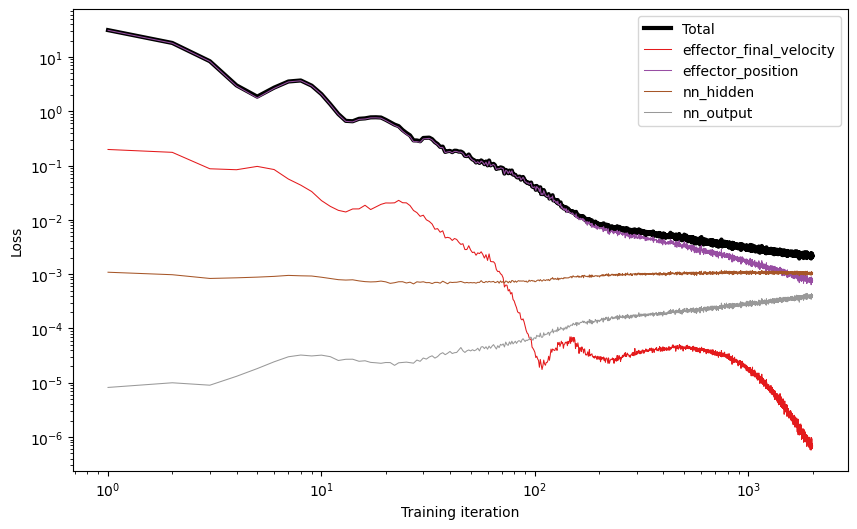

In [ ]:
from feedbax.plot import plot_losses

plot_losses(train_history)

There are four loss terms that added up to give the total. According to this particular loss function, a reach gets a good score if:

- the velocity of the effector (in this case, the point mass itself) is zero at the end of the reach,
- the position of the effector is at the goal position, near the end of the reach---for most of the training run, 
- the activity of the units in the network is small,
- the outputs of the network (in this case, the forces applied to the point mass) are small

Training means changing the model to try to improve the total score.

Well, did it learn to reach? Let's evaluate the trained model. For this purpose, `RandomReaches` also provides a set of center-out reach endpoints.

In [ ]:
task = context.task  # Shorthand, since we'll be referring to this more than once

states = task.eval(model, key=jax.random.PRNGKey(2))

(<Figure size 1200x600 with 3 Axes>,
 array([<Axes: title={'center': 'Position'}, xlabel='$x$', ylabel='$y$'>,
        <Axes: title={'center': 'Velocity'}, xlabel='$\\dot x$', ylabel='$\\dot y$'>,
        <Axes: title={'center': 'Control force'}, xlabel='$\\mathrm{f}_x$', ylabel='$\\mathrm{f}_y$'>],
       dtype=object))

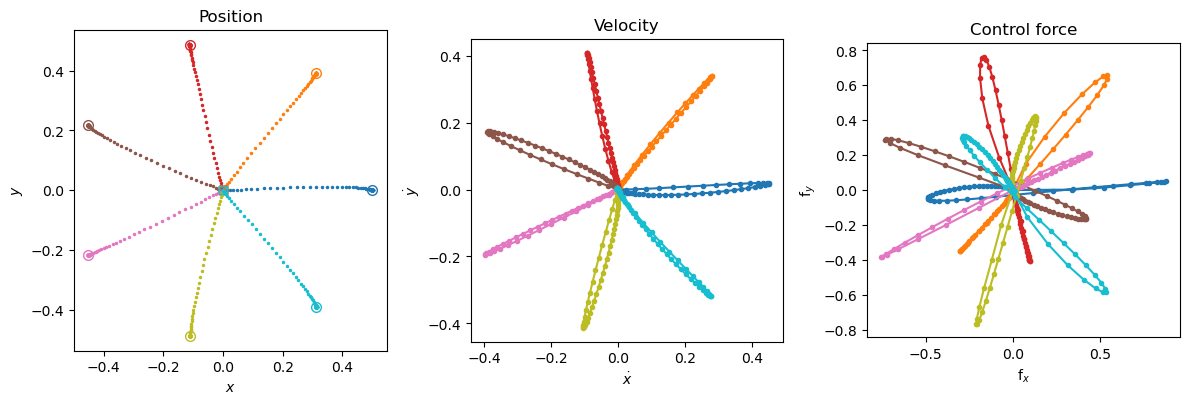

In [ ]:
from feedbax.plot import plot_reach_trajectories

plot_reach_trajectories(states, trial_specs=task.validation_trials)

Note that we've specified the `trial_specs` argument so that the goal positions of the reaches are circled. There are seven reaches here, and each one starts at $(0,0)$. 

Clearly, the network has learned to move the point mass to the target, and stop there---the velocities return to zero.

Is this an improvement over the untrained model? What would the reaches look like, prior to optimizing on the task? Keep in mind that `context.model` still refers to the untrained model.

(<Figure size 1200x600 with 3 Axes>,
 array([<Axes: title={'center': 'Position'}, xlabel='$x$', ylabel='$y$'>,
        <Axes: title={'center': 'Velocity'}, xlabel='$\\dot x$', ylabel='$\\dot y$'>,
        <Axes: title={'center': 'Control force'}, xlabel='$\\mathrm{f}_x$', ylabel='$\\mathrm{f}_y$'>],
       dtype=object))

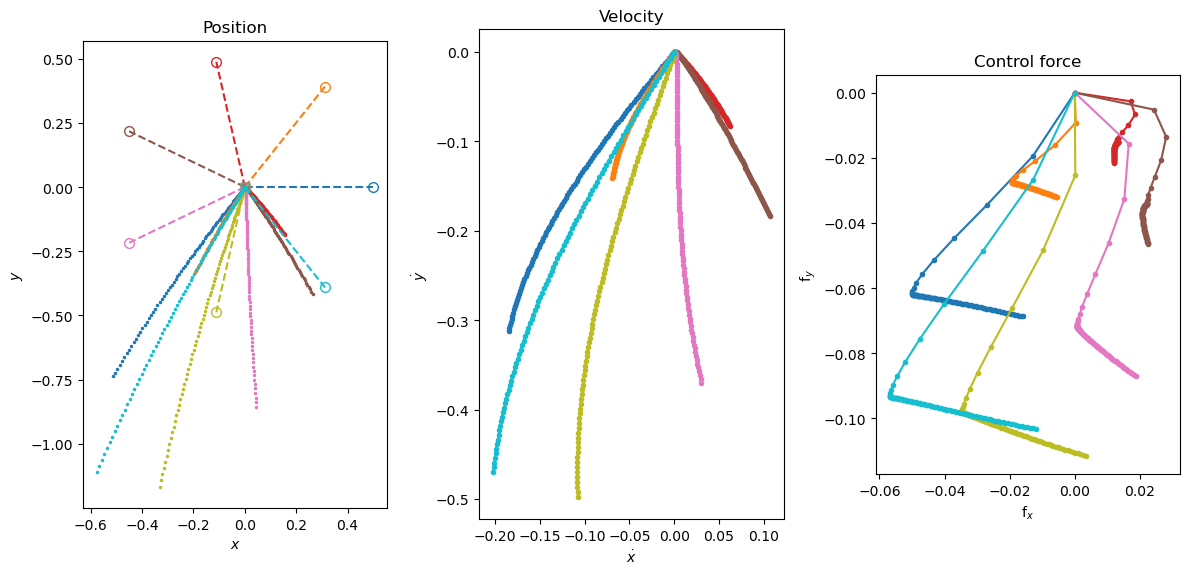

In [12]:
plot_reach_trajectories(
    task.eval(
        context.model, 
        key=jax.random.PRNGKey(2)
    ), 
    trial_specs=task.validation_trials,
    straight_guides=True,  
)

Here, we've added straight dashed lines connecting the start and goal positions of each reach, to indicate the ideal straight reach. 

Obviously, our model could not complete the task before we had trained it to do so!

## 